# VacationPy
---

## Starter Code to Import Libraries and Load the Weather and Coordinates Data

In [2]:
# Dependencies and Setup
import hvplot.pandas
import pandas as pd
import requests
from pathlib import Path

# Import API key
from api_keys import geoapify_key

In [3]:
hvplot

<module 'hvplot' from 'C:\\Users\\steve\\anaconda3\\Lib\\site-packages\\hvplot\\__init__.py'>

In [4]:
# Load the CSV file created in Part 1 into a Pandas DataFrame
csv_file = Path("output_data/cities.csv")
city_data_df = pd.read_csv(csv_file)

# Display sample data
city_data_df.head()

,City_ID,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,0,touros,-5.1989,-35.4608,29.40,66,34,5.07,BR,1693062700
1,1,labytnangi,66.6572,66.4183,6.43,83,96,4.27,RU,1693062701
2,2,port-aux-francais,-49.3500,70.2167,3.74,76,67,7.11,TF,1693062702
3,3,grytviken,-54.2811,-36.5092,-4.59,72,21,9.86,GS,1693062703
4,4,puerto natales,-51.7236,-72.4875,3.31,68,100,2.00,CL,1693062704


---

### Step 1: Create a map that displays a point for every city in the `city_data_df` DataFrame. The size of the point should be the humidity in each city.

In [5]:
# Assuming your DataFrame contains the columns 'Lng', 'Lat', and 'Humidity'
coordinates_df = city_data_df[['Lng', 'Lat' , 'City', 'Humidity']]

# Create the map using hvplot.points
map_plot_1 = coordinates_df.hvplot.points(
    "Lng",
    "Lat",
    geo=True,
    tiles="OSM",
    color="City",
    title="City Humidity Map"
)

# Display the map
map_plot_1


C:\Users\steve\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Lng,Lat]   (City)

### Step 2: Narrow down the `city_data_df` DataFrame to find your ideal weather condition

In [6]:
# Narrow down cities that fit criteria (example: humidity > 70)
narrowed_down_df = city_data_df[city_data_df['Humidity'] > 70].copy()

# Drop any rows with null values
narrowed_down_df.dropna(inplace=True)

# Display sample data
narrowed_down_df.head()



,City_ID,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
1,1,labytnangi,66.6572,66.4183,6.43,83,96,4.27,RU,1693062701
2,2,port-aux-francais,-49.3500,70.2167,3.74,76,67,7.11,TF,1693062702
3,3,grytviken,-54.2811,-36.5092,-4.59,72,21,9.86,GS,1693062703
5,5,sarnia,42.9787,-82.4041,20.07,84,100,1.54,CA,1693062652
6,6,kruisfontein,-34.0033,24.7314,11.60,73,73,9.63,ZA,1693062705


In [7]:
len(narrowed_down_df)

328

### Step 3: Create a new DataFrame called `hotel_df`.

In [10]:
# Use the Pandas copy function to create DataFrame called hotel_df to store the city, country, coordinates, and humidity
hotel_df = narrowed_down_df.copy()[['City', 'Country', 'Lat', 'Lng', 'Humidity']]

# Add an empty column, "Hotel Name," to the DataFrame
hotel_df['Hotel Name'] = ""

# Display sample data
hotel_df.head(10)


,City,Country,Lat,Lng,Humidity,Hotel Name
1,labytnangi,RU,66.6572,66.4183,83,
2,port-aux-francais,TF,-49.3500,70.2167,76,
3,grytviken,GS,-54.2811,-36.5092,72,
5,sarnia,CA,42.9787,-82.4041,84,
6,kruisfontein,ZA,-34.0033,24.7314,73,
8,vernon,CA,50.2581,-119.2691,71,
9,st. john's,CA,47.5649,-52.7093,79,
10,dunedin,NZ,-45.8742,170.5036,72,
11,waitangi,NZ,-43.9535,-176.5597,81,
12,galveston,US,29.3669,-94.9669,78,


### Step 4: For each city, use the Geoapify API to find the first hotel located within 10,000 metres of your coordinates.

In [14]:
# hotel
radius = 10000
params = {
    "categories":"accommodation.hotel",
    "apiKey": geoapify_key,
    "limit":20
}

# Print a message to follow up the hotel search
print("Starting hotel search")

# Iterate through the hotel_df DataFrame
for index, row in hotel_df.iterrows():
    # get latitude, longitude from the DataFrame
    latitude = row["Lat"]
    longitude = row["Lng"]    
    # Add the current city's latitude and longitude to the params dictionary
    params["filter"] = f"circle:{longitude},{latitude},{radius}"
    params["bias"] = f"proximity:{longitude},{latitude}"
    
    # Set base URL
    base_url = "https://api.geoapify.com/v2/places"
# Make and API request using the params dictionaty
    name_address = requests.get(base_url, params=params)
    
    # Convert the API response to JSON format
    name_address = name_address.json()
    
    # Grab the first hotel from the results and store the name in the hotel_df DataFrame
    try:
        hotel_df.loc[index, "Hotel Name"] = name_address["features"][0]["properties"]["name"]
    except (KeyError, IndexError):
        # If no hotel is found, set the hotel name as "No hotel found".
        hotel_df.loc[index, "Hotel Name"] = "No hotel found"
        
    # Log the search results
    print(f"{hotel_df.loc[index, 'City']} - nearest hotel: {hotel_df.loc[index, 'Hotel Name']}")

# Display sample data
hotel_df

Starting hotel search


C:\Users\steve\AppData\Local\Temp\ipykernel_28728\2522902548.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel_df.loc[index, "Hotel Name"] = name_address["features"][0]["properties"]["name"]


touros - nearest hotel: Pousada Atlântico
labytnangi - nearest hotel: Семь лиственниц
port-aux-francais - nearest hotel: Keravel
grytviken - nearest hotel: No hotel found
puerto natales - nearest hotel: Dorotea Patagonia Hostel
sarnia - nearest hotel: The Insignia Hotel, Sarnia, a Tribute Portfolio Hotel
kruisfontein - nearest hotel: No hotel found
thompson - nearest hotel: Thompson Inn
vernon - nearest hotel: Okanagan Royal Park Inn
st. john's - nearest hotel: Alt Hotel
dunedin - nearest hotel: Scenic Hotel Dunedin City
waitangi - nearest hotel: Hotel Chathams
galveston - nearest hotel: Comfort Inn & Suites Texas City
papatowai - nearest hotel: No hotel found
port elizabeth - nearest hotel: Waterford Hotel
hithadhoo - nearest hotel: Pebbles Inn
mossel bay - nearest hotel: Protea Hotel Mossel Bay
yellowknife - nearest hotel: No hotel found
san patricio - nearest hotel: No hotel found
marsh harbour - nearest hotel: Lofty Fig Villas
alice springs - nearest hotel: Aurora Alice Springs
por

,Lng,Lat,City,Hotel Name
0,-35.4608,-5.1989,touros,Pousada Atlântico
1,66.4183,66.6572,labytnangi,Семь лиственниц
2,70.2167,-49.3500,port-aux-francais,Keravel
3,-36.5092,-54.2811,grytviken,No hotel found
4,-72.4875,-51.7236,puerto natales,Dorotea Patagonia Hostel
...,...,...,...,...
555,145.5750,43.3236,nemuro,イーストハーバーホテル
556,42.7072,62.8551,bereznik,Отель Прибрежный
557,105.8933,34.5686,beidao,麦积大酒店
558,113.4639,34.1628,yingchuan,No hotel found


### Step 5: Add the hotel name and the country as additional information in the hover message for each city in the map.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
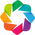

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Lng,Lat]   (City,Country)

In [21]:
%%capture --no-display
import holoviews as hv

hv.extension("bokeh")

hotel_df = city_data_df[['Lng', 'Lat', 'City', 'Country']]

# Configure the map plot with OSM tile source
map_plot = hotel_df.hvplot.points(
    "Lng",
    "Lat",
    geo=True,
    tiles="OSM",  # Use OpenStreetMap (OSM) tile source
    frame_width=700,
    frame_height=500,
    color="City",
    size=10,  # Adjust the size of the points if needed
    hover_cols=["City", "Country"],  # Specify columns for hover tooltip
    title="City Hotel Map"
)

# Display the map
map_plot
